# Tutorial PAMAP2 with mcfly

This turorial is intended to talk you through the functionalities of mcfly. As an example dataset we use the publicly available PAMAP2 dataset. It contains time series data from a variety of sensors worn by nine persons. The data is labelled with the activity types these individuals did.

Before you can start, please make sure you installed all the dependencies of mcfly (listed in requirements.txt) and make sure your jupyter notebook has a python3 kernel.

## Import required Python modules

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import numpy as np
import pandas as pd
# mcfly
from mcfly import tutorial_pamap2, modelgen, find_architecture
# Keras module is use for the deep learning
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
# We can set some backend options to avoid NaNs
from keras import backend as K

Using Theano backend.


## Download data and pre-proces data

We have created a function for you to fetch and pre-proces the data. Please specify the directory_to_extract_to and then execute the cells. The second time you run this cell it will skipp the processing and only give you the outputpath variable to indicate where the data was previously stored.

In [2]:
# Specify in which directory you want to store the data:
directory_to_extract_to = "/media/windows-share"
# Specifcy which columns to use. You can leave this as it is
columns_to_use = ['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
                 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
                 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z']
outputpath = tutorial_pamap2.fetch_and_preprocess(directory_to_extract_to,columns_to_use)

Data previously downloaded and stored in /media/windows-share/PAMAP2
Data previously pre-processed and np-files saved to /media/windows-share/PAMAP2/PAMAP2_Dataset/slidingwindow512cleaned/


## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files

In [3]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary = tutorial_pamap2.load_data(outputpath)

## Generate models

First step is to create a model architecture. As we do not know whart architecture is best for our data we will create a set of models to investigate which architecture is most suitable for our data. You will need to specificy how many models, the type of model, maximum number of layers per modeltype. See for more information the function documentation of modelgen.generate_models

In [4]:
num_classes = y_train_binary.shape[1]
models = modelgen.generate_models(X_train.shape,
                                  number_of_classes=num_classes,
                                  number_of_models = 3, #10,
                                  model_type = 'CNN',
                                  cnn_max_layers=4,
                                  deepconvlstm_max_conv_layers=3,
                                  deepconvlstm_max_lstm_layers=2)

In [5]:
# Inspect models:
models_to_print = [0,2] #range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i))
        print(" ")
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()
        print(" ")
        print("Model type:")
        print(model_types)
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0
 
Hyperparameters:
{'fc_hidden_nodes': 94, 'filters': array([30, 64, 24, 93]), 'regularization_rate': 0.021394334754425405, 'learning_rate': 0.054805486367437685}
 
Model description:
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_1 (BatchNormaliz(None, 512, 9)      18          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 512, 30)     840         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 512, 30)     60          convolution1d_1[0][0]          

## Compare models
Now the models have been generated it is time to compare the models by training them in a subset of the training data and evaluating the models in the validation subset. Performance results are stored in a json file.

In [8]:
# Define directory where the results, e.g. json file, will be stored
resultpath = directory_to_extract_to + '/PAMAP2/PAMAP2_Dataset/results/' 
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

In [9]:
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                           X_val, y_val_binary,
                                                                           models,nr_epochs=5,
                                                                           subset_size=300,
                                                                           verbose=True,
                                                                           outputfile=resultpath+\
                                                                                  'modelcomparison.json')

Training model 0 CNN
Train on 300 samples, validate on 2007 samples
Epoch 1/5
300/300 [==============================] - 19s - loss: 452.9521 - acc: 0.3933 - val_loss: 2.5331 - val_acc: 0.1639
Epoch 2/5
300/300 [==============================] - 18s - loss: 74.2489 - acc: 0.4767 - val_loss: 2.3017 - val_acc: 0.1425
Epoch 3/5
300/300 [==============================] - 18s - loss: 20.8540 - acc: 0.5167 - val_loss: 2.4379 - val_acc: 0.3921
Epoch 4/5
300/300 [==============================] - 22s - loss: 8.9444 - acc: 0.4933 - val_loss: 2.2091 - val_acc: 0.4390
Epoch 5/5
300/300 [==============================] - 22s - loss: 5.5515 - acc: 0.4767 - val_loss: 2.2765 - val_acc: 0.1345
Training model 1 CNN
Train on 300 samples, validate on 2007 samples
Epoch 1/5
300/300 [==============================] - 12s - loss: 3.2541 - acc: 0.6133 - val_loss: 1.0241 - val_acc: 0.7270
Epoch 2/5
300/300 [==============================] - 12s - loss: 2.7731 - acc: 0.8633 - val_loss: 0.9945 - val_acc: 0.8127

The histories object produced by the previous step contains the history of classifier performans with every iteration of the training process. To ease inspecting this information we developed function plotTrainingProcess, which is demonstrated in the cell below.

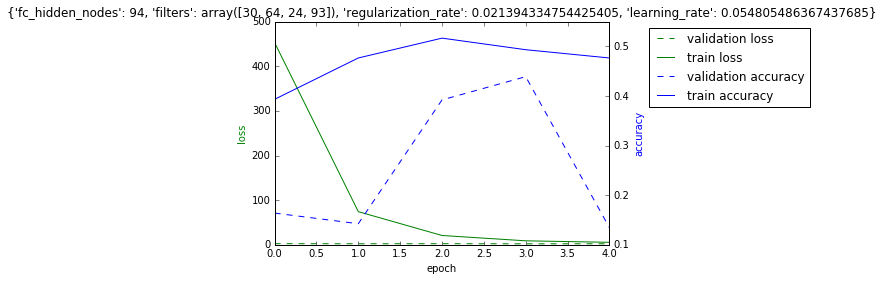

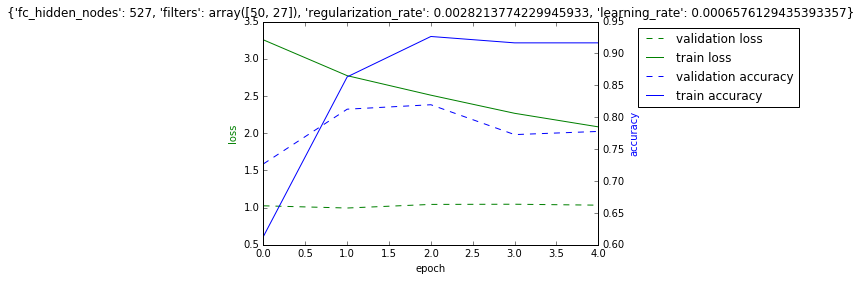

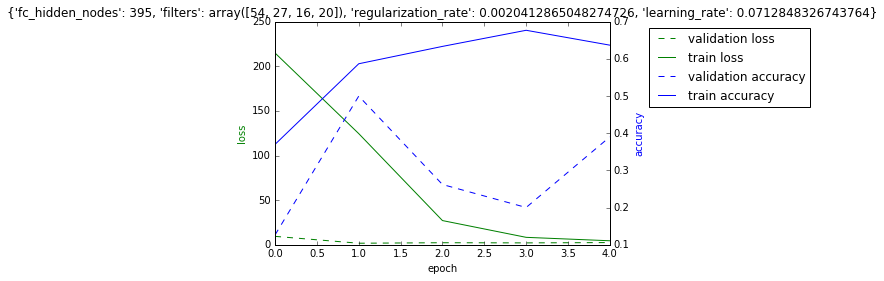

In [10]:
%matplotlib inline
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)    

Another way of comparing model performance is by putting all the information in a pandas dataframe

In [11]:
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons
modelcomparisons.to_csv(resultpath +'modelcomparisons.csv')

We can also extract the same information from the json file...

###  < - - Insert here Demo of how to use json file that was stored

## Train the best model for real

## < - - This section needs more work

In [12]:
# Inspect what is the best model
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'fc_hidden_nodes': 527, 'filters': array([50, 27]), 'regularization_rate': 0.0028213774229945933, 'learning_rate': 0.0006576129435393357}


In [13]:
#We make a copy of the model, to start training from fresh
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])

In [ ]:
#We're going to train the model on the complete data set, and save the model after each epoch
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 12497 samples, validate on 2007 samples
Epoch 1/10
12497/12497 [==============================] - 195s - loss: 0.7759 - acc: 0.9383 - val_loss: 0.3935 - val_acc: 0.9243
Epoch 2/10
 3008/12497 [======>.......................] - ETA: 170s - loss: 0.6596 - acc: 0.9525

In [ ]:
# Plot the training process:
find_architecture.plotTrainingProcess(history)

In [ ]:
best_model_copy.evaluate(X_train, y_train_binary)

In [ ]:
## Inspect model predictions
datasize = X_val.shape[0]
probs = best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)
probs

In [ ]:
score_val = best_model_copy.evaluate(X_val, y_val_binary, verbose=True)
score_val

In [ ]:
## Test on Testset
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))